In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np 
import matplotlib.pyplot as plt

In [3]:
# 생성자 model
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding="same"))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding="same", activation="tanh"))

In [4]:
# 판별자 model
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer="adam")

discriminator.trainable = False

In [5]:
# gan 모델 만들기
ginput = Input(shape=(100,))

dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss="binary_crossentropy", optimizer="adam")
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


poch:0 d_loss: 0.1143  g_loss: 4.2556
poch:1 d_loss: 0.0754  g_loss: 3.8547
poch:2 d_loss: 0.1172  g_loss: 2.8720
poch:3 d_loss: 0.2189  g_loss: 2.6459
poch:4 d_loss: 0.1092  g_loss: 4.1628
poch:5 d_loss: 0.1750  g_loss: 3.8898
poch:6 d_loss: 0.0722  g_loss: 4.2195
poch:7 d_loss: 0.1284  g_loss: 3.7294
poch:8 d_loss: 0.0840  g_loss: 3.4681
poch:9 d_loss: 0.1824  g_loss: 3.1165
poch:10 d_loss: 0.1249  g_loss: 3.4683
poch:11 d_loss: 0.1045  g_loss: 3.5610
poch:12 d_loss: 0.1058  g_loss: 2.6881
poch:13 d_loss: 0.1187  g_loss: 2.9851
poch:14 d_loss: 0.1299  g_loss: 2.6360
poch:15 d_loss: 0.0848  g_loss: 2.6611
poch:16 d_loss: 0.1250  g_loss: 3.5836
poch:17 d_loss: 0.2311  g_loss: 3.2988
poch:18 d_loss: 0.0999  g_loss: 2.8957
poch:19 d_loss: 0.1864  g_loss: 3.2277
poch:20 d_loss: 0.0844  g_loss: 3.4095
poch:21 d_loss: 0.0888  g_loss: 3.6521
poch:22 d_loss: 0.1832  g_loss: 2.8205
poch:23 d_loss: 0.1570  g_loss: 2.7340
poch:24 d_loss: 0.1199  g_loss: 2.7501
poch:25 d_loss: 0.1541  g_loss: 3.1

<ipython-input-7-820baaa20750>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


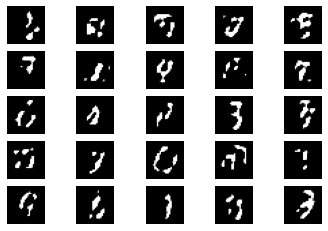

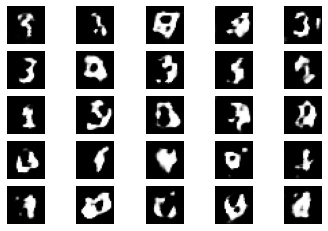

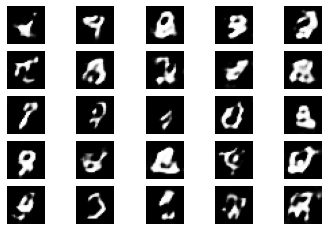

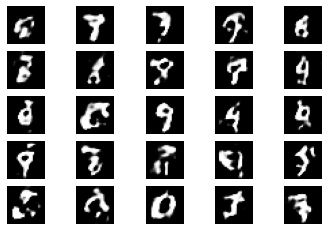

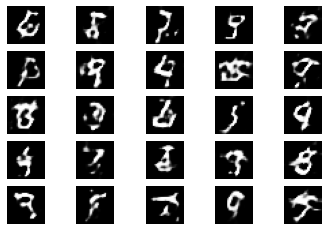

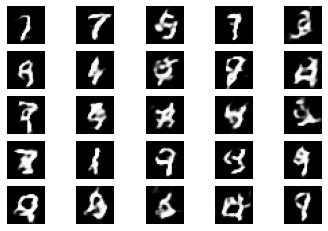

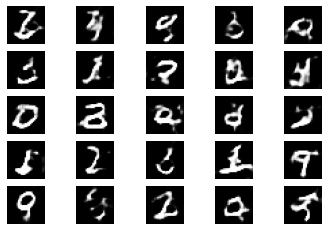

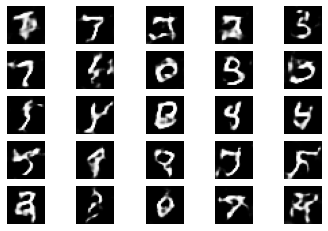

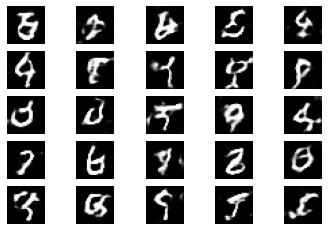

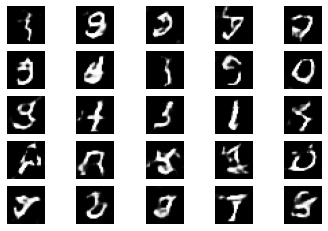

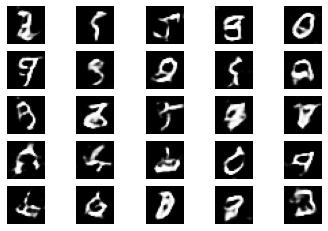

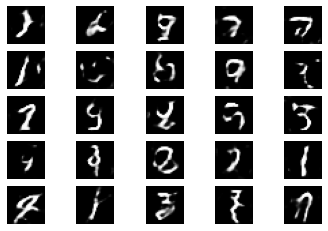

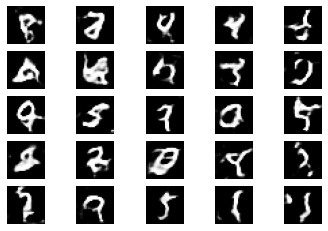

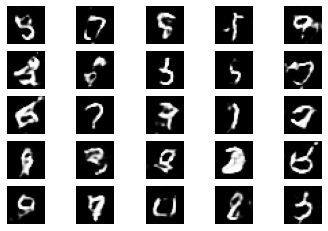

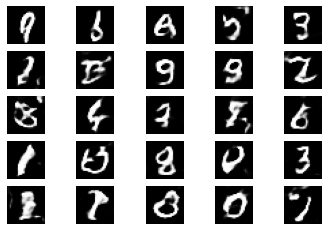

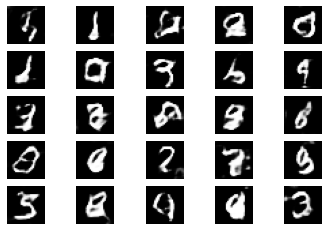

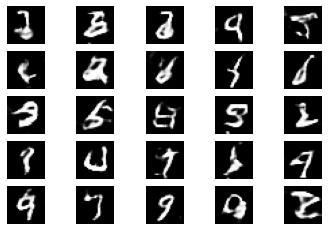

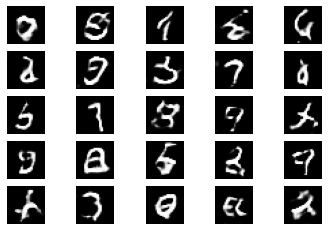

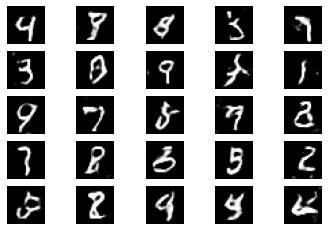

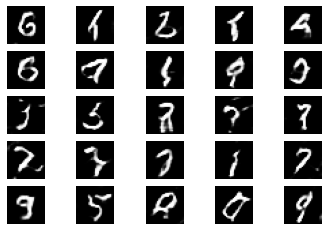

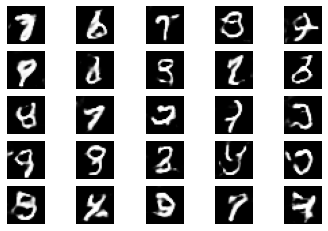

In [7]:
def gan_train(epoch, batch_size, saving_interval):
    # data load
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")

    # 127.5를 빼준 뒤 127.5로 나눠서 -1~1사이로
    X_train = (X_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print("poch:%d" % i, 'd_loss: %.4f' % d_loss, " g_loss: %.4f" % g_loss)


        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap="gray")
                    axs[j, k].axis("off")

                    count += 1
                    fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)